In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

2024-11-12 21:56:08.409738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731473769.066349  293875 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731473769.244670  293875 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 21:56:10.931746: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Question 1: Preprocessing the data (CIFAR-10)

## 1. 

Check out the shape of the train and test set and make necesary changes if required. Your X_train and X_test should have a shape like (None, 32,32,3) and your y_test and y_train must have shape like (None,).

In [2]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3) (50000, 1) (10000, 1)


In [3]:
# we need to reshape the y_train and y_test to be one dimensional
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

print(y_train.shape, y_test.shape)

(50000,) (10000,)


## 2. 

Plot the first image from the train set. What is the label for that image?

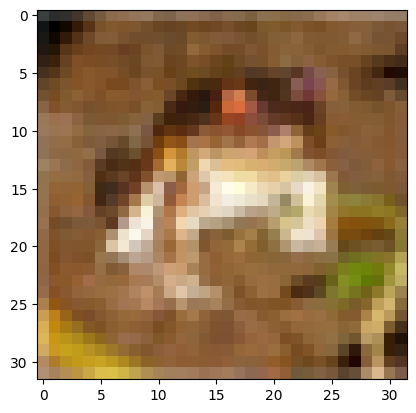

In [4]:
# plot the first image from the train dataset
import matplotlib.pyplot as plt
plt.imshow(x_train[0])
plt.show()

In [5]:
# print the label of the first image
print(y_train[0])

6


The image label is a 6 which is frogs

## 3. 

Make sure that the pixel values for x_train and x_test are normalized between 0 and 1.

In [6]:
# normalize the dataset to range 0-1
x_train = x_train / 255
x_test = x_test / 255

## 4.

This is the time to make a decision for your target variable. Note that your target variable has 10 classes. You can either leave it as it is (integers between 0 and 9) or transform it to one-hot encoded target. Whatever you pick, please specifiy which loss function you should use down the road. 

I will leave the target variable as integers because it is more memory efficient. Therefore we need to use sparse categorical cross entropy

# Question 2: Train the ANN model

Feel free to come up with any kind of ANN architecture but keep it simple though. You can use the same architecture that I used in my notebook but I encourage you trying out different number of nodes, hidden layers, activation functions and etc. There is no right or wrong answer to this part, just make sure that your input shapes are compatible with you ANN architecture (hint: You need to flatten the image first). 

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [8]:
print(f'Train set shape is: {x_train.shape}')
print(f'Test set shape is: {x_test.shape}')

Train set shape is: (50000, 32, 32, 3)
Test set shape is: (10000, 32, 32, 3)


In [9]:
# we need to flatten the images to be 1D
x_train_ann = x_train.reshape(50000, 32*32*3)
x_test_ann = x_test.reshape(10000, 32*32*3)

# normalize the dataset to range 0-1
x_train_ann = x_train_ann / 255
x_test_ann = x_test_ann / 255

In [10]:
x_train_ann.shape

(50000, 3072)

In [11]:
ann_model = keras.Sequential(name='ann_model')
ann_model.add(layers.Input(shape=(3072,)))
ann_model.add(layers.Dense(512, activation='relu', name='first_layer'))
ann_model.add(layers.Dense(256, activation='relu', name='second_layer'))

ann_model.add(layers.Dense(units=10, activation='softmax', name='output_layer'))

I0000 00:00:1731473801.813783  293875 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:03:00.0, compute capability: 8.9


In [12]:
ann_model.summary()

Model: "ann_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ first_layer (Dense)             │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ second_layer (Dense)            │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,707,274 (6.51 MB)

 Trainable params: 1,707,274 (6.51 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
ann_model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
modelcheckpoint = ModelCheckpoint(filepath='ann_model.keras', save_best_only=True, monitor='val_loss')
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
callback_list = [modelcheckpoint, earlystopping]

In [15]:
ann_model.fit(x_train_ann, y_train, validation_data=(x_test_ann, y_test), epochs=50, batch_size=128, callbacks=callback_list)

Epoch 1/50


I0000 00:00:1731473805.229954  294079 service.cc:148] XLA service 0x7f610400aa50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731473805.230211  294079 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-11-12 21:56:45.374382: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731473805.587689  294079 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-12 21:56:47.032900: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_32_0', 768 bytes spill stores, 720 bytes spill loads

2024-11-12 21:56:47.062815: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_32_0', 228 by

 25/391 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1125 - loss: 2.3023

I0000 00:00:1731473810.493732  294079 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


374/391 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1434 - loss: 2.2511

2024-11-12 21:56:52.738298: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_32_0', 756 bytes spill stores, 444 bytes spill loads

2024-11-12 21:56:52.751006: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_32', 12 bytes spill stores, 12 bytes spill loads

2024-11-12 21:56:52.985995: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_32_0', 136 bytes spill stores, 140 bytes spill loads

2024-11-12 21:56:53.078245: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_232', 36 bytes spill stores, 48 bytes spill loads

2024-11-12 21:56:53.105448: I external/local_xla/xla/stream

391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.1451 - loss: 2.2474 - val_accuracy: 0.2261 - val_loss: 2.0851
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2571 - loss: 2.0074 - val_accuracy: 0.2924 - val_loss: 1.9212
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3020 - loss: 1.9181 - val_accuracy: 0.2960 - val_loss: 1.9199
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3230 - loss: 1.8610 - val_accuracy: 0.3632 - val_loss: 1.7799
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3524 - loss: 1.7931 - val_accuracy: 0.3709 - val_loss: 1.7551
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3706 - loss: 1.7369 - val_accuracy: 0.3804 - val_loss: 1.7034
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3854 - loss: 1.6968 - val_accuracy: 0.4117 - val_loss: 1.6436
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4010 - loss: 1.6585 - val_accuracy: 0.4109 - va

In [16]:
test_model = keras.models.load_model('ann_model.keras')
test_model.evaluate(x_test_ann, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5401 - loss: 1.2925


[1.3018152713775635, 0.5393000245094299]

The ANN accuracy is at 55%. I tried adding more layers but the accuracy didn't improve much. 

# Question 3: Train the CNN model

Feel free to come up with any kind of CNN architecture but keep it simple though. You can use the same architecture that I used in my notebook but I encourage you trying out different number of conv layers, pooling layers, nodes, dense layers, activation functions and etc. There is no right or wrong answer to this part, just make sure that your input shapes are compatible with you CNN architecture. 

In [17]:
def cnn_builder():
    inputs = keras.Input(shape=(32, 32, 3), name='Input Layer')
    x = layers.Conv2D(filters=32, kernel_size = 3, strides = (1,1), padding='valid', activation='relu', name='conv_layer_1')(inputs)
    x = layers.MaxPool2D(pool_size=2, name='pooling_1')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation='relu', name='conv_layer_2')(x)
    x = layers.MaxPool2D(pool_size=2, name='pooling_2')(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation='relu', name='conv_layer_3')(x)
    x = layers.Flatten(name='flattening_layer')(x)

    outputs = layers.Dense(units=10, activation='softmax', name='output_layer')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='first_cnn_model')

    model.compile(optimizer='rmsprop',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [18]:
model = cnn_builder()
model.summary()

Model: "first_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input Layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_1 (Conv2D)           │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_1 (MaxPooling2D)        │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_2 (Conv2D)           │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_2 (MaxPooling2D)        │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_3 (Conv2D)           │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flattening_layer (Flatten)      │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,738 (444.29 KB)

 Trainable params: 113,738 (444.29 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
modelcheckpoint = ModelCheckpoint(filepath='cnn_model.keras', save_best_only=True, monitor='val_loss')
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
callback_list = [modelcheckpoint, earlystopping]

In [20]:
history = model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), epochs=50, batch_size=128, callbacks=callback_list)

Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.2793 - loss: 1.9733 - val_accuracy: 0.4319 - val_loss: 1.5809
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4800 - loss: 1.4555 - val_accuracy: 0.5239 - val_loss: 1.3343
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5654 - loss: 1.2449 - val_accuracy: 0.6174 - val_loss: 1.0931
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6148 - loss: 1.1060 - val_accuracy: 0.6242 - val_loss: 1.0736
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6544 - loss: 1.0013 - val_accuracy: 0.5890 - val_loss: 1.2020
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6883 - loss: 0.9151 - val_accuracy: 0.6673 - val_loss: 0.9684
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7065 - loss: 0.8455 - val_accuracy: 0.6865 - val_loss: 0.9057
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7273 - loss: 0.7868 - val_accuracy: 

In [21]:
cnn_test_model = keras.models.load_model('cnn_model.keras')
cnn_test_model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7311 - loss: 0.8071


[0.8128862380981445, 0.7275000214576721]

The CNN model is performing much better with 72% accuracy

# Question 4: Train the CNN model with data augmentation

In [22]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        #layers.RandomRotation(0.1),
        #layers.RandomZoom(0.2),
    ]
)

In [23]:
#build model
def CNN_builder_augmented():
  inputs = keras.Input(shape=(32, 32, 3), name = 'Input_layer')
  X = data_augmentation(inputs)
  X = layers.Rescaling(1./255)(X) # add rescaling to normalize the data
  X = layers.Reshape((32, 32, 3))(X) # explicitly set the shape to ensure the augmented data is in the correct format

  X = layers.Conv2D(filters = 32, kernel_size = 3, strides = (1,1), padding = 'valid', activation = 'relu', name = 'conv_layer_1')(inputs)
  X = layers.MaxPool2D(pool_size = 2, name = "polling_1")(X)
  X = layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu', name = "conv_layer_2")(X)
  X = layers.MaxPool2D(pool_size = 2, name = "pooling_2")(X)
  X = layers.Conv2D(filters= 128, kernel_size = 3, activation='relu', name="conv_layer_3")(X)
  X = layers.Conv2D(filters = 256, kernel_size = 3, activation = 'relu', name = "conv_layer_4")(X)

  X = layers.Flatten(name = "flattening_layer")(X)
  X = layers.Dropout(0.5)(X)

  outputs = layers.Dense(units = 10, activation = "softmax", name = "output_layer")(X)

  model = keras.Model(inputs = inputs, outputs = outputs, name = "hw5_CNN_aug_model")
  model.compile(optimizer = 'rmsprop',
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [24]:
model_augmented = CNN_builder_augmented()
model_augmented.summary()

Model: "hw5_CNN_aug_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_1 (Conv2D)           │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ polling_1 (MaxPooling2D)        │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_2 (Conv2D)           │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_2 (MaxPooling2D)        │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_3 (Conv2D)           │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_4 (Conv2D)           │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flattening_layer (Flatten)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 398,666 (1.52 MB)

 Trainable params: 398,666 (1.52 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
#add model checkpoint and early stopping
modelcheckpoint  = ModelCheckpoint("best_cnn_aug_model.keras",save_best_only=True, monitor="val_loss")
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [26]:
#train model
history_cnn_aug = model_augmented.fit(x=x_train, y=y_train, validation_data=(x_test, y_test),
          epochs=10, batch_size=128, callbacks=[modelcheckpoint, early_stopping])

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.2515 - loss: 2.0219 - val_accuracy: 0.4162 - val_loss: 1.6759
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4782 - loss: 1.4603 - val_accuracy: 0.5596 - val_loss: 1.2365
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5570 - loss: 1.2419 - val_accuracy: 0.6093 - val_loss: 1.1109
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6169 - loss: 1.0875 - val_accuracy: 0.6427 - val_loss: 1.0089
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6587 - loss: 0.9651 - val_accuracy: 0.6687 - val_loss: 0.9643
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6950 - loss: 0.8696 - val_accuracy: 0.6798 - val_loss: 0.9166
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7212 - loss: 0.7951 - val_accuracy: 0.6589 - val_loss: 1.0146
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7467 - loss: 0.7262 - val_accuracy: 0

In [27]:
cnn_aug_test_model = keras.models.load_model('best_cnn_aug_model.keras')
cnn_aug_test_model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7272 - loss: 0.8060


[0.8160256147384644, 0.7257000207901001]

# Question 5: Evaluate your best model

In [28]:
winning_model = keras.models.load_model('best_cnn_aug_model.keras')

## 1. 

Report the model summary (winning_model.summary()). How many parameters are there in the last convolutional layer in you winning model. Show me the breakdown of that number (ex. 3*3*3*50+50 = 1400)

In [29]:
winning_model.summary()

Model: "hw5_CNN_aug_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_1 (Conv2D)           │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ polling_1 (MaxPooling2D)        │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_2 (Conv2D)           │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_2 (MaxPooling2D)        │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_3 (Conv2D)           │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_4 (Conv2D)           │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flattening_layer (Flatten)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 797,334 (3.04 MB)

 Trainable params: 398,666 (1.52 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 398,668 (1.52 MB)

In the last convolutional layer there are 295,168 parameters

(3x3x128+1)x256

## 2. 

Plot the loss vs epoch for the train and validation set. At what epoch number does your model start overfitting?

In [30]:
import pandas as pd

metrics = pd.DataFrame(history_cnn_aug.history)

<Axes: >

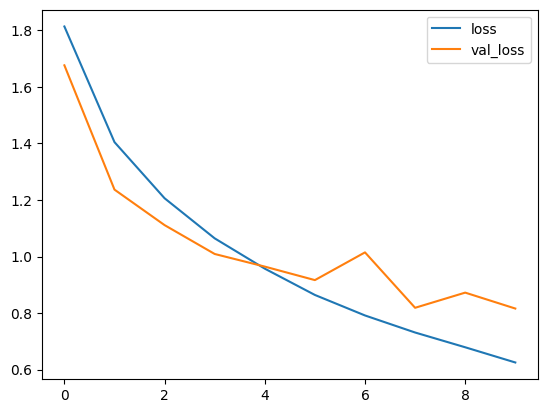

In [31]:
metrics[['loss', 'val_loss']].plot()

Here the model starts to overfit around epoch 4 because the val_loss stops decreasing with the loss in the training data.

## 3.

Import classification_report and confusion_matrix from sklearn.metrics. Print out the classification report. Based on the f1 score, which of the classes has the lowest f1 score? What does that mean?

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [33]:
pred_prob = winning_model.predict(x_test)
y_pred = np.argmax(pred_prob, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [34]:
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

              precision    recall  f1-score   support

           0       0.81      0.74      0.77      1000
           1       0.83      0.85      0.84      1000
           2       0.75      0.52      0.61      1000
           3       0.51      0.60      0.55      1000
           4       0.68      0.67      0.68      1000
           5       0.62      0.63      0.62      1000
           6       0.84      0.75      0.80      1000
           7       0.70      0.81      0.75      1000
           8       0.86      0.82      0.84      1000
           9       0.73      0.86      0.79      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000

[[739  35  22  22  20   7  10  17  63  65]
 [  6 851   5  10   7   3  12   4  10  92]
 [ 64   9 518 102  94  82  40  64   8  19]
 [ 12  13  35 596  72 149  28  54   9  32]
 [ 16   3  36  73 674  42  23 114  10   9]
 [  5   3  23 205  43 629 

Based on the output above the lowest f1 score is with class 3. This means that our model is having a hard time identifying class 3 than any other class. 

## 4. 

Use seaborn.heatmap to visualize the confusion matrix. What are the classes that your model is having a hard time distinguishing from each other? Name 3 pair of classes. 

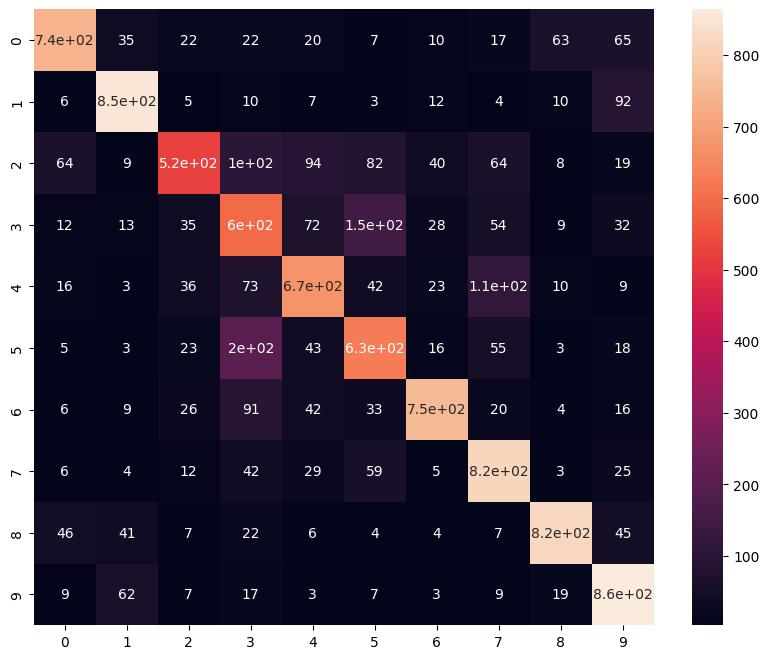

In [35]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True)
plt.show()

Recall the labels:

0. airplanes
1. cars
2. birds
3. cats
4. deer
5. dogs
6. frogs
7. horses
8. ships
9. trucks

- class 2 is being misclassified as class 3 63 times
- class 7 is being misclassified as class 2 72 times
- class 9 is being misclasiffied as class 0 87 times

## 5. 

Visualize the first 6 misclassifications of your winning model. You can borrow from code in notebook we covered in class.

In [38]:
misclassified_images = [i for i, x in enumerate(y_test!=y_pred) if x==True]
misclassified_images[:9]

[2, 4, 10, 12, 24, 26, 30, 33, 35]

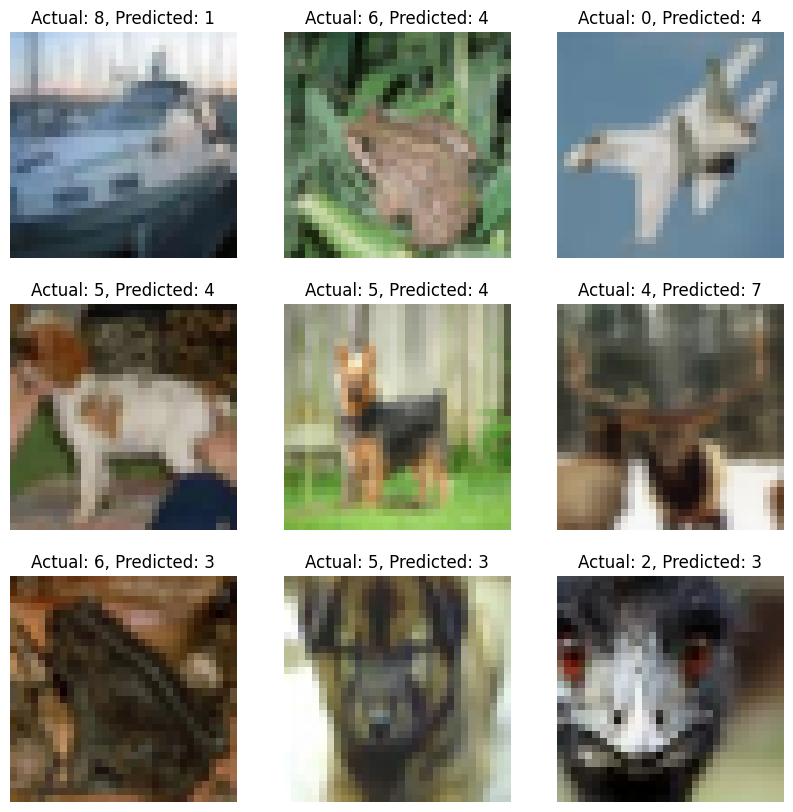

In [ ]:
plt.figure(figsize=(10, 10))

actuals = []
for i, number in enumerate(misclassified_images[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_test[number].reshape(32, 32, 3))
    actuals.append(y_test[number])
    plt.axis('off')

I was able to correctly classify each of the images shown correctly. 